# **นายวีรวัฒน์ บัวชุม รหัศนักศึกษา 62070271**

# **Description**

* **งานชิ้นนี้คือการตั้งสมติฐานเกี่ยวกับการจำแนกเอกสาร ว่าเอกสารนั้นจัดอยู่ในประเภทใด โดยมีสมมติฐานดังนี้**

  1.   การเลือกวิธีการใดในการทำ Features Extraction จะส่งผลให้ได้ Parameters ที่ให้ค่าที่เหมาะสมกับข้อมูลประเภทนั้นๆ มากที่สุด ซึ่งข้อมูลที่ใช้ในการ classify มี 2 รูปแบบคือ ข่าวที่มีเพียงเนื้อหา และข่าวที่มีทั้งหัวข้อข่าวและเนื้อหา
  2.   เมื่อได้ Parameter ที่เหมาะสมแล้วในขั้นตอนการทำ Features Extraction (เลือก parameters จากตัวที่ให้ค่า best score)จะทำการทดสอบว่า Classifier ตัวใดสามารถให้ผลลัพธ์ในการจำแนกได้ดีที่สุด



* **เบื้องต้นมีกระบวนการ ดังนี้**
  1.   Scrape Data From Source
  2.   Prepare Data สำหรับการทำ Fetures Extractionc และสำหรับเข้า Model
  3.   Text Feature Extraction
  4.   Pipeline Function
    * Find Best Parameter in Feature Extraction (function): ทำการปรับจูนหาค่าพารามิเตอร์ที่เหมาะสมกับชุดข้อมูลในการทำ Text Feature Extraction
    *   Model (functions): ฟังก์ชันแบบจำลองสำหรับเรียกใช้งาน และมีการจูนพารามิเตอร์ของแบบจำลอง
    *   Plot ROC (function): ใช้ในการพล็อต ROC Curve และแสดงข้อมูลที่เกี่ยวข้องกับ Model
    * Plot Term Document Matrix with NLTK
    * Confusion Matrix
  5.   ทำการเรียกใช้งาน Model และ Functions ที่เกี่ยวข้อง
  6.   สรุปผลการทดลอง













# **Part 1: Data Collection**

## **Import**

In [ ]:
import numpy as np
import pandas as pd
import requests
import bs4
from pprint import pprint

## **Target Web to Scape**

In [ ]:
response = requests.get('http://www.it.kmitl.ac.th/~teerapong/news_archive/index.html')
print(response)
print(type(response))

<Response [200]>
<class 'requests.models.Response'>


In [ ]:
html_page = bs4.BeautifulSoup(response.content, 'lxml')
# print(html_page)

## **Access Element by Selector**

### Scrape Month Name

> ทำการ scape ชื่อเดือนเพื่อทำการสร้าง path ในการเข้าถึงข่าวในเดือนนั้นๆ



In [ ]:
selector = 'body > div > div.main > ul > li > a'
# select return เป็น list ของ tag
tags = html_page.select(selector)

# Create HTML Path by Month 
month = []
for i in tags:
  txt = i.text.lower()[0:3]
  path = 'month-' + txt + '-2017.html'
  month.append(path)
print(month)

['month-jan-2017.html', 'month-feb-2017.html', 'month-mar-2017.html', 'month-apr-2017.html', 'month-may-2017.html', 'month-jun-2017.html', 'month-jul-2017.html', 'month-aug-2017.html', 'month-sep-2017.html', 'month-oct-2017.html', 'month-nov-2017.html', 'month-dec-2017.html']


### Scrape News Title Each Month

> ทำการ scape HREF ของทุกข่าวในแต่ละเดือน



In [ ]:
def new_title():
  data = {'Category': [], 'HREF': [], 'Title': [], 'Month': []}

  # Access Month
  for m in month:
    response = requests.get(f'http://www.it.kmitl.ac.th/~teerapong/news_archive/{m}')
    html_page = bs4.BeautifulSoup(response.content, 'lxml')

    # Selector
    selector_category = 'body > div > div.main > table > tbody > tr > td.category'
    selector_href = 'body > div > div.main > table > tbody > tr > td.title'

    tags_category = html_page.select(selector_category)
    tags_href = html_page.select(selector_href)

    # Get Data(category, href, title, month)
    for i in range(len(tags_category)):
      if (tags_category[i].text).strip() != "N/A":
        data['Category'].append(tags_category[i].text.strip())
        data['HREF'].append(tags_href[i].a['href'])
        data['Title'].append(tags_href[i].a.text)
        data['Month'].append(m)
  
  return pd.DataFrame(data)

In [ ]:
# Create Title DataFrame
all_news = new_title()
all_news.iloc[0::50]

,Category,HREF,Title,Month
0,technology,article-jan-0418.html,21st-Century Sports: How Digital Technology Is...,month-jan-2017.html
50,business,article-jan-4182.html,German growth goes into reverse,month-jan-2017.html
100,business,article-jan-2864.html,Split-caps pay £194m compensation,month-jan-2017.html
150,business,article-feb-1000.html,Dollar hovers around record lows,month-feb-2017.html
200,technology,article-feb-1308.html,PC ownership to 'double by 2010',month-feb-2017.html
250,technology,article-mar-1595.html,Broadband challenges TV viewing,month-mar-2017.html
300,sport,article-mar-3153.html,Johnson uncertain about Euro bid,month-mar-2017.html
350,business,article-mar-4111.html,Virgin Blue shares plummet 20%,month-mar-2017.html
400,business,article-apr-3718.html,Latin America sees strong growth,month-apr-2017.html
450,business,article-apr-0361.html,Turkey turns on the economic charm,month-apr-2017.html


### Scrape Context

> ทำการ scrape เนื้อหาข่าวของแต่ละเดือน



In [ ]:
def getContext(df_name):
  href = np.array(df_name['HREF'])
  lst_context = []

  for n in range(len(href)):
    response = requests.get(f'http://www.it.kmitl.ac.th/~teerapong/news_archive/{href[n]}')
    html_page = bs4.BeautifulSoup(response.content, 'lxml')

    # select return เป็น list ของ tag
    selector = 'body > div > div.main > p'
    tags = html_page.select(selector)

    # รวบรวมเบื้อหาของข่าวแต่ละบรรทัด
    context = ""
    for i in range(len(tags)): 
      if tags[i].text == all_news['Title'][n] or tags[i].text == 'Return to article search results' or tags[i].text == 'Comments are closed for this article.': 
        continue
      else:
        context += tags[i].text
    lst_context.append(context)
  
  return lst_context

In [ ]:
all_news['Context'] = getContext(all_news)

In [ ]:
all_news.head(5)

,Category,HREF,Title,Month,Context
0,technology,article-jan-0418.html,21st-Century Sports: How Digital Technology Is...,month-jan-2017.html,The sporting industry has come a long way sinc...
1,business,article-jan-0027.html,Asian quake hits European shares,month-jan-2017.html,Shares in Europe's leading reinsurers and trav...
2,technology,article-jan-0631.html,BT offers free net phone calls,month-jan-2017.html,BT is offering customers free internet telepho...
3,business,article-jan-2105.html,Barclays shares up on merger talk,month-jan-2017.html,Shares in UK banking group Barclays have risen...
4,sport,article-jan-3300.html,Barkley fit for match in Ireland,month-jan-2017.html,England centre Olly Barkley has been passed fi...


In [ ]:
all_news.shape

(1408, 5)

In [ ]:
all_news['Title + Context'] = all_news.Title + ' ' + all_news.Context
all_news

,Category,HREF,Title,Month,Context,Title + Context
0,technology,article-jan-0418.html,21st-Century Sports: How Digital Technology Is...,month-jan-2017.html,The sporting industry has come a long way sinc...,21st-Century Sports: How Digital Technology Is...
1,business,article-jan-0027.html,Asian quake hits European shares,month-jan-2017.html,Shares in Europe's leading reinsurers and trav...,Asian quake hits European shares Shares in Eur...
2,technology,article-jan-0631.html,BT offers free net phone calls,month-jan-2017.html,BT is offering customers free internet telepho...,BT offers free net phone calls BT is offering ...
3,business,article-jan-2105.html,Barclays shares up on merger talk,month-jan-2017.html,Shares in UK banking group Barclays have risen...,Barclays shares up on merger talk Shares in UK...
4,sport,article-jan-3300.html,Barkley fit for match in Ireland,month-jan-2017.html,England centre Olly Barkley has been passed fi...,Barkley fit for match in Ireland England centr...
...,...,...,...,...,...,...
1403,sport,article-dec-2238.html,Woodward eyes Brennan for Lions,month-dec-2017.html,Toulouse's former Irish international Trevor B...,Woodward eyes Brennan for Lions Toulouse's for...
1404,business,article-dec-2334.html,WorldCom trial starts in New York,month-dec-2017.html,"The trial of Bernie Ebbers, former chief execu...",WorldCom trial starts in New York The trial of...
1405,business,article-dec-2095.html,Yukos accused of lying to court,month-dec-2017.html,Russian oil firm Yukos lied to a US court in a...,Yukos accused of lying to court Russian oil fi...
1406,business,article-dec-1351.html,Yukos drops banks from court bid,month-dec-2017.html,Russian oil company Yukos has dropped the thre...,Yukos drops banks from court bid Russian oil c...


### Save Data

In [ ]:
# All  Only Context
np.savetxt(r'/content/drive/MyDrive/Colab Notebooks/Data Sci/Assignment_2/data/datastore/AllArticles_OnlyContent.txt', all_news['Context'].values, fmt='%s')

# All Header + Content
np.savetxt(r'/content/drive/MyDrive/Colab Notebooks/Data Sci/Assignment_2/data/datastore/AllArticles_HeadingPlusContent.txt', all_news['Title + Context'].values, fmt='%s')

# All Class Label
np.savetxt(r'/content/drive/MyDrive/Colab Notebooks/Data Sci/Assignment_2/data/target/target.txt', all_news['Category'].values, fmt='%s')

In [ ]:
# Save Each Context
for i in range(len(all_news)):
  content_name = str(i) + '_' + 'content' + '_' + all_news['HREF'][i].split('.')[0] + '.txt'
  heading_name = str(i) + '_' + 'heading' + '_' + all_news['HREF'][i].split('.')[0] + '.txt'
  heading_plus_content_name = str(i) + '_' + 'heading_plus_content' + '_' + all_news['HREF'][i].split('.')[0] + '.txt'
  np.savetxt(r'/content/drive/MyDrive/Colab Notebooks/Data Sci/Assignment_2/data/datastore/content/' +  content_name, [all_news['Context'][i]], fmt='%s')
  np.savetxt(r'/content/drive/MyDrive/Colab Notebooks/Data Sci/Assignment_2/data/datastore/heading/' +  heading_name, [all_news['Title'][i]], fmt='%s')
  np.savetxt(r'/content/drive/MyDrive/Colab Notebooks/Data Sci/Assignment_2/data/datastore/heading_plus_content/' +  heading_plus_content_name, [all_news['Title + Context'][i]], fmt='%s')

# **Part 2: Text Classification**

## **Description Part 2: Text Classification**

> ในส่วนนี้จะทำการจัดเตรียมข้อมูลให้สามารถนำเข้า model ได้โดยมีกระบวนการดังนี้

* 1. Text Feature Extraction Functions
* 2. Preparing Data
* 3. Multi Class Classification Models
* 4. Pipeline Function
* 5. Apply Model






## **Text Feature Extraction Functions**

> อัลกอริทึมที่เลือกมาใช้ Stemmer, Lemmatizer with POS สาเหตุที่เลือก Lemmatizer with POS มาเพียงอย่างเดียวเนื่องจากการใช้ Lemmatizer ควรใช้คู่กับรูปแบบที่ ยังคงสภาพหน้าที่ของคำเอาไว้

* 1. Stemmer (Porter Stemmer, Snowball Stemmer)
* 2. Lemmatizer with POS



In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### 1.Porter Stemmer

In [ ]:
# define the function
def stem_tokenizer_porter(text):
    # use the standard scikit-learn tokenizer
    standard_tokenizer = TfidfVectorizer().build_tokenizer()
    tokens = standard_tokenizer(text)
    # then use NLTK to perform stemming on each token (PorterStemmer)
    stemmer = PorterStemmer()
    stems = []
    for token in tokens:
        stems.append( stemmer.stem( token.lower()) )

    return stems

### 2.Snowball Stemmer

In [ ]:
# define the function
def stem_tokenizer_snowball(text):
    # use the standard scikit-learn tokenizer first
    standard_tokenizer = TfidfVectorizer().build_tokenizer()
    tokens = standard_tokenizer(text)
    # then use NLTK to perform stemming on each token (SnowballStemmer)
    stemmer = SnowballStemmer()
    stems = []
    for token in tokens:
        stems.append( stemmer.stem(token.lower()) )
  
    return stems

### 3.Lemmatizer with POS tagging

In [ ]:
#-----------------------------------------Tokenizer and WordNet Lemmatizer with POS--------------------------------------
# define the function
def lemma_tokenizer_w_pos_tag(text):
    # define a nested function for converting POS tag for Lemmatizer
    def convert_tags(tag):
        if tag == 'vbd' or tag == 'vbg' or tag == 'vbz':
            return 'v'
        else: 
            return 'n'
    
    #-----------------------------------------------Using WordNet Lemmatizer-----------------------------------------
    # use the standard scikit-learn tokenizer first
    standard_tokenizer = TfidfVectorizer().build_tokenizer()
    tokens = standard_tokenizer(text)
    tokens_with_pos_tag = nltk.pos_tag(tokens)
    # print(tokens_with_pos_tag)
    # then use NLTK to perform lemmatisation on each token
    lemmatizer = nltk.WordNetLemmatizer()
    lemma_tokens = []
    for token in tokens_with_pos_tag:
        new_tag = convert_tags(token[1].lower())
        lemma_tokens.append(lemmatizer.lemmatize(token[0], new_tag))

    return lemma_tokens

## **Preparing Data**

> สร้าง DataFrame สำหรับเข้า Model



### Raw Data

In [ ]:
# All Articals Only Context
!gdown --id 18AKAVTVJEPEy79vz3g2ZB4eAiSko-Sbf -O 'AllArticles_OnlyContent.txt'
fin = open("AllArticles_OnlyContent.txt","r")
doc_content = fin.readlines()
fin.close()
print("Read doc_content: %d raw text documents" % len(doc_content))
print()

# All Articles Heading + Content
!gdown --id 1--amjMOeJnIFbWVoNkwWsx5jpLz10g9C -O 'AllArticles_HeadingPlusContent.txt'
fin = open("AllArticles_HeadingPlusContent.txt","r")
doc_Hcontent = fin.readlines()
fin.close()
print("Read doc_Hcontent: %d raw text documents" % len(doc_Hcontent))
print()

# Target
!gdown --id 18QAMEuXlHv0Bnjm7MHrPtBT6RXwl9sNB -O 'target.txt'
fin = open("target.txt","r")
doc_target = fin.readlines()
fin.close()
print("Read doc_target: %d raw text documents" % len(doc_target))
print()

Downloading...
From: https://drive.google.com/uc?id=18AKAVTVJEPEy79vz3g2ZB4eAiSko-Sbf
To: /content/AllArticles_OnlyContent.txt
100% 3.17M/3.17M [00:00<00:00, 48.8MB/s]
Read doc_content: 1408 raw text documents

Downloading...
From: https://drive.google.com/uc?id=1--amjMOeJnIFbWVoNkwWsx5jpLz10g9C
To: /content/AllArticles_HeadingPlusContent.txt
100% 3.21M/3.21M [00:00<00:00, 95.9MB/s]
Read doc_Hcontent: 1408 raw text documents

Downloading...
From: https://drive.google.com/uc?id=18QAMEuXlHv0Bnjm7MHrPtBT6RXwl9sNB
To: /content/target.txt
100% 11.9k/11.9k [00:00<00:00, 8.79MB/s]
Read doc_target: 1408 raw text documents



### Create DataFrame

In [ ]:
df = pd.DataFrame({
    'heading_content': doc_Hcontent,
    'only_content': doc_content,
    'label': doc_target
})

In [ ]:
df

,heading_content,only_content,label
0,21st-Century Sports: How Digital Technology Is...,The sporting industry has come a long way sinc...,technology\n
1,Asian quake hits European shares Shares in Eur...,Shares in Europe's leading reinsurers and trav...,business\n
2,BT offers free net phone calls BT is offering ...,BT is offering customers free internet telepho...,technology\n
3,Barclays shares up on merger talk Shares in UK...,Shares in UK banking group Barclays have risen...,business\n
4,Barkley fit for match in Ireland England centr...,England centre Olly Barkley has been passed fi...,sport\n
...,...,...,...
1403,Woodward eyes Brennan for Lions Toulouse's for...,Toulouse's former Irish international Trevor B...,sport\n
1404,WorldCom trial starts in New York The trial of...,"The trial of Bernie Ebbers, former chief execu...",business\n
1405,Yukos accused of lying to court Russian oil fi...,Russian oil firm Yukos lied to a US court in a...,business\n
1406,Yukos drops banks from court bid Russian oil c...,Russian oil company Yukos has dropped the thre...,business\n


### Clean data

> จากการอ่านไฟล์ข้อมูลในรูปแบบของ text เข้ามาพบว่าเมื่อทำการแปลงข้อมูลเป็น DataFrame แล้ว ยังมีคำที่เพิ่มเกินมาจากรูปแบบของ text ติดมาด้วยคือ "/n" จึงต้องทำการตัดออก



In [ ]:
df['heading_content'] = df['heading_content'].apply(lambda x: x.replace('\n', ''))
df['only_content'] = df['only_content'].apply(lambda x: x.replace('\n', ''))
df['label'] = df['label'].apply(lambda x: x.replace('\n', ''))

In [ ]:
df['heading_content'][18]

'Cebit opens to mobile music tune Cebit, the world\'s largest hi-tech fair, has opened its doors in Hanover for a look at the latest technologies for homes and businesses.There are more than 6,000 exhibitors registered and about 500,000 visitors are expected to pass through the doors. Third generation mobiles, the digital home and broadband are key themes at the show. Camera phones will get better resolutions as vendors set out to prove that bigger is definitely better. Samsung is set to steal some initial limelight with the launch of a 7-megapixel phone on the opening day.The SCH-V770 has some of the features of high-end digital single lens reflex cameras such as manual focus and the ability to attach a telephoto or wide-angle lens. Camera phones are likely to prove an interesting battle ground at the show, said Ben Wood, principal analyst at research firm Gartner. "It is firmly established that cameras are an integral part of phones and now the technology arms race is on in terms of 

In [ ]:
df['only_content'][18]

'Cebit, the world\'s largest hi-tech fair, has opened its doors in Hanover for a look at the latest technologies for homes and businesses.There are more than 6,000 exhibitors registered and about 500,000 visitors are expected to pass through the doors. Third generation mobiles, the digital home and broadband are key themes at the show. Camera phones will get better resolutions as vendors set out to prove that bigger is definitely better. Samsung is set to steal some initial limelight with the launch of a 7-megapixel phone on the opening day.The SCH-V770 has some of the features of high-end digital single lens reflex cameras such as manual focus and the ability to attach a telephoto or wide-angle lens. Camera phones are likely to prove an interesting battle ground at the show, said Ben Wood, principal analyst at research firm Gartner. "It is firmly established that cameras are an integral part of phones and now the technology arms race is on in terms of megapixels. There will be a certa

In [ ]:
df['label'][18]

'technology'

In [ ]:
df

,heading_content,only_content,label
0,21st-Century Sports: How Digital Technology Is...,The sporting industry has come a long way sinc...,technology
1,Asian quake hits European shares Shares in Eur...,Shares in Europe's leading reinsurers and trav...,business
2,BT offers free net phone calls BT is offering ...,BT is offering customers free internet telepho...,technology
3,Barclays shares up on merger talk Shares in UK...,Shares in UK banking group Barclays have risen...,business
4,Barkley fit for match in Ireland England centr...,England centre Olly Barkley has been passed fi...,sport
...,...,...,...
1403,Woodward eyes Brennan for Lions Toulouse's for...,Toulouse's former Irish international Trevor B...,sport
1404,WorldCom trial starts in New York The trial of...,"The trial of Bernie Ebbers, former chief execu...",business
1405,Yukos accused of lying to court Russian oil fi...,Russian oil firm Yukos lied to a US court in a...,business
1406,Yukos drops banks from court bid Russian oil c...,Russian oil company Yukos has dropped the thre...,business


### Encoding Label

> ทำการแปลง class ของ Label ให้อยู่ในรูปแบบของตัวเลขเพื่อให้สามารถเข้าแบบจำลองได้ (['business', 'sport', 'technology'] ---> [0, 1, 2])



In [ ]:
encode = preprocessing.LabelEncoder()
encode.fit(list(set(df['label'])))
list(encode.classes_)

['business', 'sport', 'technology']

In [ ]:
df['label'] = encode.transform(df[['label']])
df

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,heading_content,only_content,label
0,21st-Century Sports: How Digital Technology Is...,The sporting industry has come a long way sinc...,2
1,Asian quake hits European shares Shares in Eur...,Shares in Europe's leading reinsurers and trav...,0
2,BT offers free net phone calls BT is offering ...,BT is offering customers free internet telepho...,2
3,Barclays shares up on merger talk Shares in UK...,Shares in UK banking group Barclays have risen...,0
4,Barkley fit for match in Ireland England centr...,England centre Olly Barkley has been passed fi...,1
...,...,...,...
1403,Woodward eyes Brennan for Lions Toulouse's for...,Toulouse's former Irish international Trevor B...,1
1404,WorldCom trial starts in New York The trial of...,"The trial of Bernie Ebbers, former chief execu...",0
1405,Yukos accused of lying to court Russian oil fi...,Russian oil firm Yukos lied to a US court in a...,0
1406,Yukos drops banks from court bid Russian oil c...,Russian oil company Yukos has dropped the thre...,0


### Drop Duplicate

> ทำการตัดเนื้อข่าวที่ซ้ำกันออก (ในส่วนนี้ที่ได้ทำการตัดเนื้อข่าวที่ซ้ำกันออก เนื่องจากการที่ข่าวซ้ำกันแต่มี category ที่แตกต่างกันอาจจะส่งผลต่อการพยากรณ์ที่ให้ค่าความแม่นยำที่ลดลง)



In [ ]:
df = df.drop_duplicates(['only_content'], keep="first")
df.shape

(1340, 3)

### DataFrame For Conclusion

> DataFrame สำหรับแสดงผลลัพธ์ประสิทธิภาพของแต่ละ Model



In [ ]:
conclusion = {
    'Model Name': [],
    'Type of Data': [],
    'Train Accuracy(%)': [],
    'Test Accuaracy(%)': [],
    'ROC Score(%)': []
  }

### Data For Model

> ข้อมูลสำหรับใช้เข้า Model



In [ ]:
# data
X1 = df['only_content']
X2 = df['heading_content']
y = df['label']

## **Multi Class Classification Models**

> Model สำหรับเรียกใช้งานพร้อมทำการจูนพารามิเตอร์





### **Classifier Description (อธิบายเหตุผลการเลือกใช้ classifiers)**
ข้อมูลที่ต้องการทำการพยากรณ์อยู่ในรูปแบบ multi class จึงเลือกใช้ model ที่รองรับการทำ multi class classifying และอยากรู้ว่า classifier ตัวใดที่ให้ผลลัพธ์ได้ดีที่สุด

> **Logistic Regression**

> **KNeighbors Classifier**

> **Gradient Boosting Classifier**

> **Multinomial Naive Bayes**









In [ ]:
# Import the libraries we will be using
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import plot_confusion_matrix

import matplotlib.pylab as plt
%matplotlib inline

### 1.Logistic Regression

In [ ]:
def tune_logistic_regression(X_train, X_test, y_train, y_test):
  # hyperparameters LogisticRegression
  hyperparameters = dict(C=np.logspace(0, 5, num=10), penalty=['l1', 'l2'], solver=['liblinear'])
  logistic = linear_model.LogisticRegression()
  gridsearch = GridSearchCV(logistic, hyperparameters)
  best_model = gridsearch.fit(X_train, y_train)

  # Call logistic regression function
  model, y_pred_train, y_pred, y_prob_pred, y_test = logistic_regression(X_train, X_test, y_train, y_test, best_model.best_estimator_)

  return model, y_pred_train, y_pred, y_prob_pred, y_test, best_model.best_params_

In [ ]:
def logistic_regression(X_train, X_test, y_train, y_test, log_regression_tuning):
  
  log_regress = log_regression_tuning
  log_regress.fit(X_train, y_train)

  # Predict
  y_pred_train = log_regress.predict(X_train)
  y_pred = log_regress.predict(X_test)
  y_prob_pred = log_regress.predict_proba(X_test)

  return log_regress, y_pred_train, y_pred, y_prob_pred, y_test

### 2.KNeighbors Classifier

In [ ]:
def tuning_knn(X_train, X_test, y_train, y_test):
  #List Hyperparameters that we want to tune.
  leaf_size = list(range(1, 10))
  n_neighbors = list(range(1, 20))
  p=[1,2]

  #Convert to dictionary
  hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

  #Create new KNN object
  knn_2 = KNeighborsClassifier()

  #Use GridSearch
  clf = GridSearchCV(knn_2, hyperparameters, cv=5)

  #Fit model
  best_model = clf.fit(X_train, y_train)

  # Call KNN function
  model, y_pred_train, y_pred, y_prob_pred, y_test = knn(X_train, X_test, y_train, y_test, best_model.best_estimator_)

  return model, y_pred_train, y_pred, y_prob_pred, y_test, best_model.best_params_

In [ ]:
def knn(X_train, X_test, y_train, y_test, knn_tuningModel):
  neigh = knn_tuningModel
 
  # Predict
  y_pred_train = neigh.predict(X_train)
  y_pred = neigh.predict(X_test)
  y_prob_pred = neigh.predict_proba(X_test)

  return neigh, y_pred_train, y_pred, y_prob_pred, y_test

### 3.Gradient Boosting Classifier

In [ ]:
def tune_gbc(X_train, X_test,y_train, y_test):
  # hyperparameters GradientBoostingClassifier
  gbc = GradientBoostingClassifier()
  parameters = {
    'n_estimators': range(100, 200, 25),
    'max_features': ['auto', 'sqrt'],
    'max_depth': [1, 3, 5, 7],
    'min_samples_split': range(2, 6),
    'min_samples_leaf': range(1, 4)
  }

  cv = RandomizedSearchCV(gbc, param_distributions = parameters, cv=5)
  # Fit model
  cv.fit(X_train, y_train)

  # Predict
  y_pred_train = cv.best_estimator_.predict(X_train)
  y_pred = cv.best_estimator_.predict(X_test)
  y_prob_pred = cv.best_estimator_.predict_proba(X_test)

  return cv.best_estimator_, y_pred_train, y_pred, y_prob_pred, y_test, cv.best_params_

### 4.MultinomialNB

In [ ]:
def tune_naiveBayes_classifier(X_train, X_test, y_train, y_test):
  # hyperparameters NaiveBayes_classifier
  params = {'alpha': np.logspace(0.01, 5, num=100)}
  multinomial_nb_grid = GridSearchCV(MultinomialNB(), param_grid=params, n_jobs=-1, cv=5, verbose=2)
  multinomial_nb_grid.fit(X_train, y_train)

  # Call naiveBayes_classifier function
  model, y_pred_train, y_pred, y_prob_pred, y_test = naiveBayes_classifier(X_train, X_test, y_test, multinomial_nb_grid.best_estimator_)

  return model, y_pred_train, y_pred, y_prob_pred, y_test, multinomial_nb_grid.best_estimator_

In [ ]:
def naiveBayes_classifier(X_train, X_test, y_test, best_model):

  clf = best_model

  # Predict
  y_pred_train = clf.predict(X_train)
  y_pred = clf.predict(X_test)
  y_prob_pred = clf.predict_proba(X_test)


  return clf, y_pred_train, y_pred, y_prob_pred, y_test

## **Pipeline Function**

### 1.Find Best Parameters in Fetures Extraction Process

> ทำการจูนเพื่อหาว่าการทำ Feature Extraction แบบใดที่สามารถให้พารามิเตอร์ที่เหมาะสมกับ ข้อมูลชุดนั้นๆ โดยทำการวัดประสิทธิภาพจาก Classification ที่ได้ทำการ Input เข้าไป



In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
def find_best_param_feturesXtraction(X, y, model):
  # Split data
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

  # Create pipeline (ใน pipeline ประกอบไปด้วย Vectorizer, classifier)
  pipeline = Pipeline([ ('tfidf', TfidfVectorizer()), ('classifier', model) ])

  # Set range off params
  random = {
      'tfidf__ngram_range': [(1, 1), (2, 1)],
      'tfidf__stop_words': ['english'],
      'tfidf__min_df': np.arange(3, 13),
      'tfidf__tokenizer': [stem_tokenizer_snowball, stem_tokenizer_porter, lemma_tokenizer_w_pos_tag]
  }

  random_search = RandomizedSearchCV(pipeline, param_distributions = random, scoring = 'accuracy', n_jobs=-1, cv=5, verbose=2, n_iter = 20)
  random_search.fit(X_train, y_train)

  # Collect bestParam, bestScore
  bestParam = random_search.best_params_
  bestScore = random_search.best_score_


  return bestParam['tfidf__tokenizer'], bestParam['tfidf__ngram_range'], bestParam['tfidf__min_df'], bestScore, X_train, X_test, y_train, y_test, bestParam

### 2.Tranform Data

> ทำการแปลงข้อมูลให้อยู่ในรูปที่ สามารถใช้ในการเข้าแบบจำลอง



In [ ]:
def tranform_data(tokenizer_name, num_min_df, n_gramRange, X_train, X_test, y_train, y_test):
  # vectorizer
  vectorizer = TfidfVectorizer(stop_words="english", min_df = num_min_df, tokenizer = tokenizer_name, ngram_range = n_gramRange)
  vectorizer.fit(X_train)

  # tranfrom
  X_train_vecTranform = vectorizer.transform(X_train)
  X_test_vecTranform = vectorizer.transform(X_test)

  return X_train_vecTranform, X_test_vecTranform, y_train, y_test, vectorizer.fit(X_train)

### 3.Plot ROC Function

> Plot roc curve และแสดงข้อมูลที่เกี่ยวข้องกับการทำ classifier



In [ ]:
def plot_roc(model, y_pred_train, y_pred, y_prob_pred, y_train, y_test, model_name, type_X, x_train_shape, x_test_shape, best_param, bestParam_fet, bestScore_fet):
  #roc auc score
  roc_acc = roc_auc_score(y_test, y_prob_pred, multi_class='ovo', average='weighted') * 100

  # Accuracy Score
  train_acc = accuracy_score(y_train, y_pred_train) * 100
  test_acc = accuracy_score(y_test, y_pred) * 100

  print()
  print('--------------------------------------------------')
  print(f'{model_name} And X is {type_X}')
  print('--------------------------------------------------')
  print()
  
  print("Best Parameters From Fetures Extraction Process")
  print(f"tfidf__tokenizer: {bestParam_fet['tfidf__tokenizer']}")
  print(f"tfidf__stop_words: {bestParam_fet['tfidf__stop_words']}")
  print(f"tfidf__ngram_range: {bestParam_fet['tfidf__ngram_range']}")
  print(f"tfidf__min_df: {bestParam_fet['tfidf__min_df']}")
  print(f"Best Score in Tuning: {round(bestScore_fet*100, 3)} %")
  print()
  
  print('--------------------------------------------------')
  
  print()
  print(f"X Train: {x_train_shape}")
  print(f"X Test: {x_test_shape}")
  print(f'Train Accuracy: {round(train_acc, 3)} %')
  print(f'Test Accuracy: {round(test_acc, 3)} %')
  print(f'ROC Socre: {round(roc_acc, 3)} %')
  print()

  print('--------------------------------------------------')
  print()
  print(f'Best Parameters From Tuning Model: {best_param}')

  # roc curve for classes
  fpr, tpr, thresh = {}, {}, {}

  for i in range(3):    
      fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_prob_pred[:,i], pos_label=i)
      
  # plotting    
  plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 1')
  plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 2')
  plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 3')
  plt.plot([0, 1], [0, 1], linestyle='dashed', color='black')
  plt.title(f'{model_name} And X is {type_X}')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive rate')
  plt.legend(loc='best')
  plt.savefig('Multiclass ROC',dpi=300);

  print('--------------------------------------------------')
  print()

  return model_name, type_X, train_acc, test_acc, roc_acc, bestParam_fet, best_param


### 4.Plot Term Document Matrix with NLTK

In [ ]:
def term_doc_matrix(data, vect):
  # plot term document matrix 
  td = pd.DataFrame( data.todense() )
  td.columns = vect.get_feature_names()
  term_document_matrix = td.T

  term_document_matrix['total_weight'] = term_document_matrix.sum(axis=1)
  term_document_matrix = term_document_matrix.sort_values(by ='total_weight', ascending=False)
  
  return term_document_matrix.T

### 5.Confusion Matrix

In [ ]:
def confsionM(y_test, y_pred):
  # plot confusion matrix
  cf_matrix = confusion_matrix(y_test, y_pred)
  cnf_df = pd.DataFrame(cf_matrix,
                      index = ['Business', 'Sport', 'Technology'], 
                      columns = ['Business', 'Sport', 'Technology'])

  ax = plt.axes()
  sns.heatmap(cnf_df, annot=True, fmt='', cmap='Dark2', ax = ax)
  ax.set_title('Confusion Matrix')
  plt.show()

## **Apply Model**

> ในการ Apply Model มีกระบวนการในการทำงานดังนี้

1.   ทำการจูนเพื่อหาว่าการทำ Feature Extraction แบบใดที่สามารถให้พารามิเตอร์ที่เหมาะสมกับ ข้อมูลชุดนั้นๆ โดยทำการวัดประสิทธิภาพจาก Classification ที่ได้ทำการ Input เข้าไป


2.   เมื่อทราบแล้วว่าควรใช้ Parameters ใดในการ Feature Extraction (ในส่วนนี้จะใช้การถ่วงน้ำหนักคำแบบ TfidfVectorizer) ก็จะทำการแปลงข้อมูลให้อยู่ในรูปที่ สามารถใช้ในการเข้าแบบจำลอง โดยใช้ Parameters และข้อมูลที่ได้มาจากการจูนในข้อ 1


3.   นำข้อมูลที่แปลงเรียบร้อยแล้วจากในข้อ 2 ไปเข้า Multi Classifier Model ในการเข้า model จะมีการ Tuning parameter เพื่อหาค่า best estimator มาใช้ในการ classifying 


4.   ทำการแสดงข้อมูล Parameters ต่างๆที่ได้จากการจูน   แสดงค่าความแม่นยำในการพยากรณ์ และทำการแสดง ROC Curve 





### 1.1.Use Logistic Regression: Only Content

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.8min finished



--------------------------------------------------
Logistic Regression And X is Only Content
--------------------------------------------------

Best Parameters From Fetures Extraction Process
tfidf__tokenizer: <function stem_tokenizer_porter at 0x7f5f6eb18dd0>
tfidf__stop_words: english
tfidf__ngram_range: (1, 1)
tfidf__min_df: 11
Best Score in Tuning: 97.949 %

--------------------------------------------------

X Train: (1072, 2508)
X Test: (268, 2508)
Train Accuracy: 99.907 %
Test Accuracy: 98.134 %
ROC Socre: 99.902 %

--------------------------------------------------

Best Parameters From Tuning Model: {'C': 3.5938136638046276, 'penalty': 'l2', 'solver': 'liblinear'}
--------------------------------------------------



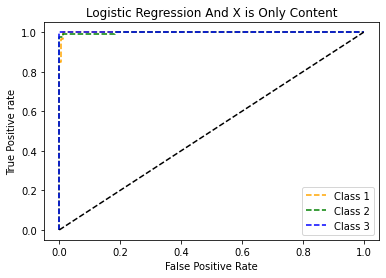

In [ ]:
# Find Best Parameters in Fetures Extraction Process
tokenizer_name, n_gramRange, num_min_df, bestScore, X1_train, X1_test, y1_train, y1_test, bestParam_fet = find_best_param_feturesXtraction(X1, y, LogisticRegression())

# tranform data
X1_train_vecTranform, X1_test_vecTranform, y1_train, y1_test, vec_fit = tranform_data(tokenizer_name, num_min_df, n_gramRange, X1_train, X1_test, y1_train, y1_test)

# model
model, y1_pred_train, y1_pred, y1_prob_pred, y1_test, best_param = tune_logistic_regression(X1_train_vecTranform, X1_test_vecTranform, y1_train, y1_test)

# plot roc
model_name, type_X, train_acc, test_acc, roc_auc, bestParam_fet, best_param = plot_roc(model, y1_pred_train, y1_pred, y1_prob_pred, y1_train, y1_test, 'Logistic Regression', 'Only Content', X1_train_vecTranform.shape, X1_test_vecTranform.shape, best_param, bestParam_fet, bestScore)

# keep data for conclusion
conclusion['Model Name'].append(model_name)
conclusion['Type of Data'].append(type_X)
conclusion['Train Accuracy(%)'].append(train_acc)
conclusion['Test Accuaracy(%)'].append(test_acc)
conclusion['ROC Score(%)'].append(roc_auc)

Confusion Matrix

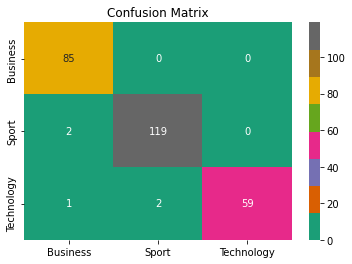

In [ ]:
confsionM(y1_test, y1_pred)

Term Document Matrix

In [ ]:
# Term Document Matrix 
doc_term = term_doc_matrix(X1_train_vecTranform, vec_fit)
doc_term

,said,wa,ha,game,year,hi,thi,mr,play,compani,new,use,firm,peopl,player,time,world,market,win,sale,bank,like,make,news,share,club,england,say,team,mobil,unit,month,price,set,technolog,onlin,just,expect,countri,second,...,properli,firewal,explod,83,background,clip,expos,hide,abandon,stun,embrac,hook,triumph,professor,load,numer,flash,compromis,overwhelm,implic,shame,subsequ,relev,immers,wake,repeatedli,hot,27bn,conveni,evas,vega,compat,embarrass,truli,cd,harder,stream,suppos,notic,savvi
0,0.052885,0.014460,0.080919,0.000000,0.047796,0.000000,0.033374,0.077126,0.000000,0.000000,0.000000,0.023458,0.000000,0.097167,0.026290,0.020134,0.000000,0.000000,0.000000,0.000000,0.000000,0.069639,0.045770,0.049675,0.000000,0.000000,0.000000,0.000000,0.000000,0.078271,0.000000,0.000000,0.000000,0.026653,0.095458,0.025671,0.025013,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.052008,0.000000,0.026526,0.097565,0.031335,0.041688,0.032820,0.000000,0.098675,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.379914,0.000000,0.000000,0.000000,0.000000,0.048851,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050491,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.055039,0.030099,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052213,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.053199,0.000000,0.000000,0.000000,0.000000,0.047634,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050841,0.000000,0.000000,0.000000,0.000000,0.156193,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.129054,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.038283,0.035705,0.000000,0.016872,0.011223,0.070684,0.000000,0.000000,0.076441,0.065610,0.062103,0.000000,0.012862,0.013920,0.010661,0.012040,0.000000,0.000000,0.000000,0.000000,0.036873,0.000000,0.013151,0.000000,0.000000,0.000000,0.012637,0.000000,0.000000,0.000000,0.012933,0.000000,0.000000,0.016848,0.027185,0.013244,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.032830,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.032830,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.032351,0.000000,0.000000,0.000000,0.031908,0.000000,0.000000,0.000000
4,0.104687,0.000000,0.000000,0.000000,0.000000,0.055943,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.069388,0.000000,0.060016,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090460,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078381,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.

### 1.2.Use Logistic Regression: Heading + Content

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.9min finished



--------------------------------------------------
Logistic Regression And X is Heading + Content
--------------------------------------------------

Best Parameters From Fetures Extraction Process
tfidf__tokenizer: <function stem_tokenizer_porter at 0x7f5f6eb18dd0>
tfidf__stop_words: english
tfidf__ngram_range: (1, 1)
tfidf__min_df: 4
Best Score in Tuning: 98.136 %

--------------------------------------------------

X Train: (1072, 4952)
X Test: (268, 4952)
Train Accuracy: 99.907 %
Test Accuracy: 98.507 %
ROC Socre: 99.886 %

--------------------------------------------------

Best Parameters From Tuning Model: {'C': 3.5938136638046276, 'penalty': 'l2', 'solver': 'liblinear'}
--------------------------------------------------



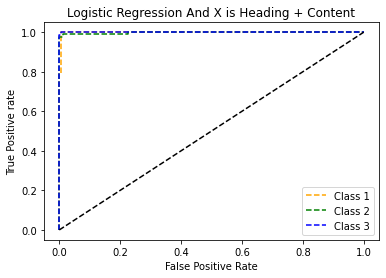

In [ ]:
# Find Best Parameters in Fetures Extraction Process
tokenizer_name, n_gramRange, num_min_df, bestScore, X2_train, X2_test, y2_train, y2_test, bestParam_fet = find_best_param_feturesXtraction(X2, y, LogisticRegression())

# tranform data
X2_train_vecTranform, X2_test_vecTranform, y2_train, y2_test, vec_fit = tranform_data(tokenizer_name, num_min_df, n_gramRange, X2_train, X2_test, y2_train, y2_test)

# model
model, y2_pred_train, y2_pred, y2_prob_pred, y2_test, best_param = tune_logistic_regression(X2_train_vecTranform, X2_test_vecTranform, y2_train, y2_test)

# plot roc
model_name, type_X, train_acc, test_acc, roc_auc, bestParam_fet, best_param = plot_roc(model, y2_pred_train, y2_pred, y2_prob_pred, y2_train, y2_test, 'Logistic Regression', 'Heading + Content', X2_train_vecTranform.shape, X2_test_vecTranform.shape, best_param, bestParam_fet, bestScore)

# keep data for conclusion
conclusion['Model Name'].append(model_name)
conclusion['Type of Data'].append(type_X)
conclusion['Train Accuracy(%)'].append(train_acc)
conclusion['Test Accuaracy(%)'].append(test_acc)
conclusion['ROC Score(%)'].append(roc_auc)

Confusion Matrix

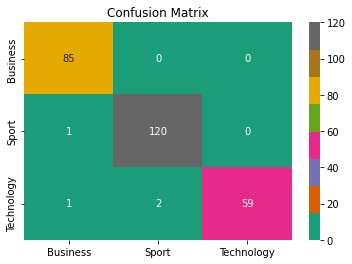

In [ ]:
confsionM(y2_test, y2_pred)

Term Document Matrix

In [ ]:
# Term Document Matrix 
doc_term = term_doc_matrix(X2_train_vecTranform, vec_fit)
doc_term

,said,wa,ha,game,year,hi,thi,mr,play,new,use,compani,peopl,firm,player,time,market,world,win,bank,sale,england,like,news,mobil,make,share,say,club,team,price,technolog,onlin,month,set,phone,unit,expect,just,rate,...,tame,zoom,1976,misunderstood,marketplac,rocket,joel,tick,isl,maduaka,recreat,warrant,pie,mighti,useless,indulg,camcord,brutal,sadli,helm,bedroom,mode,girlfriend,aftermath,grate,diy,qwerti,portion,olympian,wire,tinker,dawn,drama,fraction,illustr,couch,complement,script,exponenti,feroci
0,0.048161,0.013169,0.073691,0.000000,0.043483,0.000000,0.030392,0.070237,0.000000,0.000000,0.021362,0.000000,0.088487,0.000000,0.023941,0.018293,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.063336,0.045174,0.071279,0.041101,0.000000,0.000000,0.000000,0.000000,0.000000,0.086931,0.023344,0.000000,0.023941,0.035416,0.000000,0.000000,0.022779,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.065462
1,0.046922,0.000000,0.023932,0.087900,0.028243,0.037566,0.029611,0.000000,0.088899,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.339476,0.000000,0.000000,0.000000,0.000000,0.044012,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045487,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
2,0.048914,0.026749,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.046336,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.047211,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.041743,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045183,0.000000,0.000000,0.000000,0.000000,0.138812,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
3,0.000000,0.037121,0.034621,0.000000,0.016343,0.010869,0.068537,0.000000,0.000000,0.063322,0.060217,0.074119,0.012472,0.000000,0.013497,0.010313,0.000000,0.011659,0.000000,0.000000,0.000000,0.000000,0.035707,0.012734,0.000000,0.000000,0.000000,0.012172,0.000000,0.000000,0.000000,0.016336,0.026321,0.012540,0.000000,0.000000,0.000000,0.000000,0.012842,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035849,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
4,0.081173,0.000000,0.000000,0.000000,0.000000,0.043325,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.053803,0.000000,0.000000,0.046476,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070141,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000

### 2.1Use KNeighbors Classifier: Only Content

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.5min finished



--------------------------------------------------
KNeighbors Classifier And X is Only Content
--------------------------------------------------

Best Parameters From Fetures Extraction Process
tfidf__tokenizer: <function stem_tokenizer_porter at 0x7f5f6eb18dd0>
tfidf__stop_words: english
tfidf__ngram_range: (1, 1)
tfidf__min_df: 4
Best Score in Tuning: 97.015 %

--------------------------------------------------

X Train: (1072, 4931)
X Test: (268, 4931)
Train Accuracy: 97.575 %
Test Accuracy: 96.269 %
ROC Socre: 99.522 %

--------------------------------------------------

Best Parameters From Tuning Model: {'leaf_size': 1, 'n_neighbors': 10, 'p': 2}
--------------------------------------------------



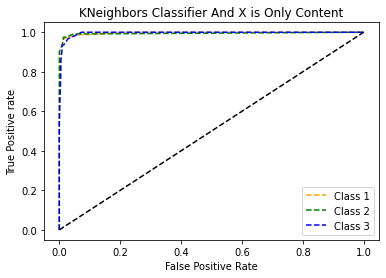

In [ ]:
# Find Best Parameters in Fetures Extraction Process
tokenizer_name, n_gramRange, num_min_df, bestScore, X1_train, X1_test, y1_train, y1_test, bestParam_fet = find_best_param_feturesXtraction(X1, y, KNeighborsClassifier())

# tranform data
X1_train_vecTranform, X1_test_vecTranform, y1_train, y1_test, vec_fit = tranform_data(tokenizer_name, num_min_df, n_gramRange, X1_train, X1_test, y1_train, y1_test)

# model
model, y1_pred_train, y1_pred, y1_prob_pred, y1_test, best_param = tuning_knn(X1_train_vecTranform, X1_test_vecTranform, y1_train, y1_test)

# plot roc
model_name, type_X, train_acc, test_acc, roc_auc, bestParam_fet, best_param = plot_roc(model, y1_pred_train, y1_pred, y1_prob_pred, y1_train, y1_test, 'KNeighbors Classifier', 'Only Content', X1_train_vecTranform.shape, X1_test_vecTranform.shape, best_param, bestParam_fet, bestScore)

# keep data for conclusion
conclusion['Model Name'].append(model_name)
conclusion['Type of Data'].append(type_X)
conclusion['Train Accuracy(%)'].append(train_acc)
conclusion['Test Accuaracy(%)'].append(test_acc)
conclusion['ROC Score(%)'].append(roc_auc)

Confusion Matrix

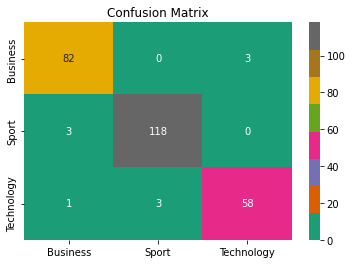

In [ ]:
# Confusion Matrix
confsionM(y1_test, y1_pred)

Term Document Matrix 

In [ ]:
# Term Document Matrix 
doc_term = term_doc_matrix(X1_train_vecTranform, vec_fit)
doc_term

,said,wa,ha,game,year,hi,thi,mr,play,use,compani,new,peopl,player,firm,time,market,world,win,sale,bank,like,news,england,make,club,say,share,mobil,team,price,month,technolog,onlin,unit,set,just,expect,phone,servic,...,1976,hing,assert,tame,zoom,gym,rocket,misunderstood,pie,marketplac,helm,warrant,isl,joel,maduaka,recreat,brutal,useless,camcord,mighti,sadli,bedroom,indulg,mode,aftermath,girlfriend,qwerti,grate,portion,olympian,wire,dawn,drama,fraction,couch,illustr,complement,script,exponenti,feroci
0,0.049170,0.013445,0.075234,0.000000,0.044438,0.000000,0.031029,0.071708,0.000000,0.021810,0.000000,0.000000,0.090340,0.024443,0.000000,0.018719,0.000000,0.000000,0.000000,0.000000,0.000000,0.064746,0.046185,0.000000,0.042554,0.000000,0.000000,0.000000,0.072772,0.000000,0.000000,0.000000,0.088752,0.023868,0.000000,0.024781,0.023256,0.000000,0.036271,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066833
1,0.051140,0.000000,0.026083,0.095938,0.030813,0.040993,0.032273,0.000000,0.097029,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.373578,0.000000,0.000000,0.000000,0.048036,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.049649,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.052198,0.028545,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.049518,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050454,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045175,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.048217,0.000000,0.000000,0.000000,0.000000,0.148131,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.037215,0.034708,0.000000,0.016401,0.010910,0.068711,0.000000,0.000000,0.060369,0.074307,0.063779,0.012503,0.013532,0.000000,0.010363,0.000000,0.011704,0.000000,0.000000,0.000000,0.035844,0.012784,0.000000,0.000000,0.000000,0.012285,0.000000,0.000000,0.000000,0.000000,0.012572,0.016378,0.026426,0.000000,0.000000,0.012875,0.000000,0.000000,0.016246,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035940,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.089198,0.000000,0.000000,0.000000,0.000000,0.047665,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.059122,0.000000,0.000000,0.000000,0.051136,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.077075,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.

### 2.2.Use KNeighbors Classifier: Heading + Content

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  97 out of 100 | elapsed:  7.8min remaining:   14.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.0min finished



--------------------------------------------------
KNeighbors Classifier And X is Heading + Content
--------------------------------------------------

Best Parameters From Fetures Extraction Process
tfidf__tokenizer: <function stem_tokenizer_porter at 0x7f5f6eb18dd0>
tfidf__stop_words: english
tfidf__ngram_range: (1, 1)
tfidf__min_df: 4
Best Score in Tuning: 96.922 %

--------------------------------------------------

X Train: (1072, 4952)
X Test: (268, 4952)
Train Accuracy: 97.854 %
Test Accuracy: 95.896 %
ROC Socre: 98.565 %

--------------------------------------------------

Best Parameters From Tuning Model: {'leaf_size': 1, 'n_neighbors': 5, 'p': 2}
--------------------------------------------------



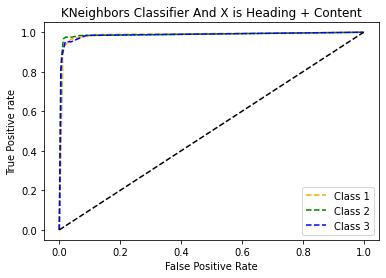

In [ ]:
# Find Best Parameters in Fetures Extraction Process
tokenizer_name, n_gramRange, num_min_df, bestScore, X2_train, X2_test, y2_train, y2_test, bestParam_fet = find_best_param_feturesXtraction(X2, y, KNeighborsClassifier())

# tranform data
X2_train_vecTranform, X2_test_vecTranform, y2_train, y2_test, vec_fit = tranform_data(tokenizer_name, num_min_df, n_gramRange, X2_train, X2_test, y2_train, y2_test)

# model
model, y2_pred_train, y2_pred, y2_prob_pred, y2_test, best_param = tuning_knn(X2_train_vecTranform, X2_test_vecTranform, y2_train, y2_test)

# plot roc
model_name, type_X, train_acc, test_acc, roc_auc, bestParam_fet, best_param = plot_roc(model, y2_pred_train, y2_pred, y2_prob_pred, y2_train, y2_test, 'KNeighbors Classifier', 'Heading + Content', X2_train_vecTranform.shape, X2_test_vecTranform.shape, best_param, bestParam_fet, bestScore)

# keep data for conclusion
conclusion['Model Name'].append(model_name)
conclusion['Type of Data'].append(type_X)
conclusion['Train Accuracy(%)'].append(train_acc)
conclusion['Test Accuaracy(%)'].append(test_acc)
conclusion['ROC Score(%)'].append(roc_auc)

Confusion Matrix

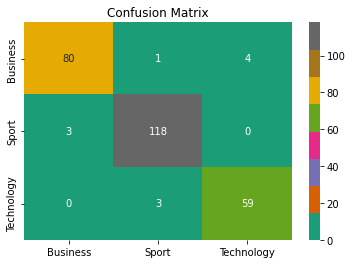

In [ ]:
# Confusion Matrix
confsionM(y2_test, y2_pred)

Term Document Matrix 

In [ ]:
# Term Document Matrix 
doc_term = term_doc_matrix(X2_train_vecTranform, vec_fit)
doc_term

,said,wa,ha,game,year,hi,thi,mr,play,new,use,compani,peopl,firm,player,time,market,world,win,bank,sale,england,like,news,mobil,make,share,say,club,team,price,technolog,onlin,month,set,phone,unit,expect,just,rate,...,tame,zoom,1976,misunderstood,marketplac,rocket,joel,tick,isl,maduaka,recreat,warrant,pie,mighti,useless,indulg,camcord,brutal,sadli,helm,bedroom,mode,girlfriend,aftermath,grate,diy,qwerti,portion,olympian,wire,tinker,dawn,drama,fraction,illustr,couch,complement,script,exponenti,feroci
0,0.048161,0.013169,0.073691,0.000000,0.043483,0.000000,0.030392,0.070237,0.000000,0.000000,0.021362,0.000000,0.088487,0.000000,0.023941,0.018293,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.063336,0.045174,0.071279,0.041101,0.000000,0.000000,0.000000,0.000000,0.000000,0.086931,0.023344,0.000000,0.023941,0.035416,0.000000,0.000000,0.022779,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.065462
1,0.046922,0.000000,0.023932,0.087900,0.028243,0.037566,0.029611,0.000000,0.088899,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.339476,0.000000,0.000000,0.000000,0.000000,0.044012,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045487,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
2,0.048914,0.026749,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.046336,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.047211,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.041743,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045183,0.000000,0.000000,0.000000,0.000000,0.138812,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
3,0.000000,0.037121,0.034621,0.000000,0.016343,0.010869,0.068537,0.000000,0.000000,0.063322,0.060217,0.074119,0.012472,0.000000,0.013497,0.010313,0.000000,0.011659,0.000000,0.000000,0.000000,0.000000,0.035707,0.012734,0.000000,0.000000,0.000000,0.012172,0.000000,0.000000,0.000000,0.016336,0.026321,0.012540,0.000000,0.000000,0.000000,0.000000,0.012842,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035849,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
4,0.081173,0.000000,0.000000,0.000000,0.000000,0.043325,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.053803,0.000000,0.000000,0.046476,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070141,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000

### 3.1.Use Gradient Boosting Classifier: Only Content

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.8min finished



--------------------------------------------------
Gradient Boosting Classifier And X is Only Content
--------------------------------------------------

Best Parameters From Fetures Extraction Process
tfidf__tokenizer: <function stem_tokenizer_porter at 0x7f5f6eb18dd0>
tfidf__stop_words: english
tfidf__ngram_range: (1, 1)
tfidf__min_df: 4
Best Score in Tuning: 96.363 %

--------------------------------------------------

X Train: (1072, 4931)
X Test: (268, 4931)
Train Accuracy: 100.0 %
Test Accuracy: 97.388 %
ROC Socre: 99.786 %

--------------------------------------------------

Best Parameters From Tuning Model: {'n_estimators': 100, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 7}
--------------------------------------------------



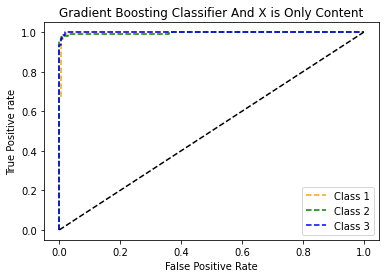

In [ ]:
# Find Best Parameters in Fetures Extraction Process
tokenizer_name, n_gramRange, num_min_df, bestScore, X1_train, X1_test, y1_train, y1_test, bestParam_fet = find_best_param_feturesXtraction(X1, y, GradientBoostingClassifier())

# tranform data
X1_train_vecTranform, X1_test_vecTranform, y1_train, y1_test, vec_fit = tranform_data(tokenizer_name, num_min_df, n_gramRange, X1_train, X1_test, y1_train, y1_test)

# model
model, y1_pred_train, y1_pred, y1_prob_pred, y1_test, best_param = tune_gbc(X1_train_vecTranform, X1_test_vecTranform, y1_train, y1_test)

# plot roc
model_name, type_X, train_acc, test_acc, roc_auc, bestParam_fet, best_param = plot_roc(model, y1_pred_train, y1_pred, y1_prob_pred, y1_train, y1_test, 'Gradient Boosting Classifier', 'Only Content', X1_train_vecTranform.shape, X1_test_vecTranform.shape, best_param, bestParam_fet, bestScore)

# keep data for conclusion
conclusion['Model Name'].append(model_name)
conclusion['Type of Data'].append(type_X)
conclusion['Train Accuracy(%)'].append(train_acc)
conclusion['Test Accuaracy(%)'].append(test_acc)
conclusion['ROC Score(%)'].append(roc_auc)

Confusion Matrix

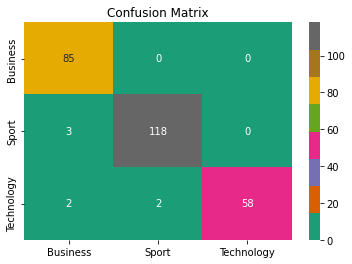

In [ ]:
# Confusion Matrix
confsionM(y1_test, y1_pred)

Term Document Matrix 

In [ ]:
# Term Document Matrix 
doc_term = term_doc_matrix(X1_train_vecTranform, vec_fit)
doc_term

,said,wa,ha,game,year,hi,thi,mr,play,use,compani,new,peopl,player,firm,time,market,world,win,sale,bank,like,news,england,make,club,say,share,mobil,team,price,month,technolog,onlin,unit,set,just,expect,phone,servic,...,1976,hing,assert,tame,zoom,gym,rocket,misunderstood,pie,marketplac,helm,warrant,isl,joel,maduaka,recreat,brutal,useless,camcord,mighti,sadli,bedroom,indulg,mode,aftermath,girlfriend,qwerti,grate,portion,olympian,wire,dawn,drama,fraction,couch,illustr,complement,script,exponenti,feroci
0,0.049170,0.013445,0.075234,0.000000,0.044438,0.000000,0.031029,0.071708,0.000000,0.021810,0.000000,0.000000,0.090340,0.024443,0.000000,0.018719,0.000000,0.000000,0.000000,0.000000,0.000000,0.064746,0.046185,0.000000,0.042554,0.000000,0.000000,0.000000,0.072772,0.000000,0.000000,0.000000,0.088752,0.023868,0.000000,0.024781,0.023256,0.000000,0.036271,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066833
1,0.051140,0.000000,0.026083,0.095938,0.030813,0.040993,0.032273,0.000000,0.097029,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.373578,0.000000,0.000000,0.000000,0.048036,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.049649,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.052198,0.028545,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.049518,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050454,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045175,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.048217,0.000000,0.000000,0.000000,0.000000,0.148131,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.037215,0.034708,0.000000,0.016401,0.010910,0.068711,0.000000,0.000000,0.060369,0.074307,0.063779,0.012503,0.013532,0.000000,0.010363,0.000000,0.011704,0.000000,0.000000,0.000000,0.035844,0.012784,0.000000,0.000000,0.000000,0.012285,0.000000,0.000000,0.000000,0.000000,0.012572,0.016378,0.026426,0.000000,0.000000,0.012875,0.000000,0.000000,0.016246,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035940,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.089198,0.000000,0.000000,0.000000,0.000000,0.047665,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.059122,0.000000,0.000000,0.000000,0.051136,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.077075,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.

### 3.2.Use Gradient Boosting Classifier: Heading + Content

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 16.8min finished



--------------------------------------------------
Gradient Boosting Classifier And X is Heading + Content
--------------------------------------------------

Best Parameters From Fetures Extraction Process
tfidf__tokenizer: <function stem_tokenizer_porter at 0x7f5f6eb18dd0>
tfidf__stop_words: english
tfidf__ngram_range: (1, 1)
tfidf__min_df: 12
Best Score in Tuning: 96.549 %

--------------------------------------------------

X Train: (1072, 2379)
X Test: (268, 2379)
Train Accuracy: 100.0 %
Test Accuracy: 97.388 %
ROC Socre: 99.807 %

--------------------------------------------------

Best Parameters From Tuning Model: {'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 7}
--------------------------------------------------



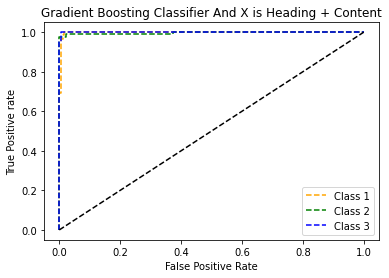

In [ ]:
# Find Best Parameters in Fetures Extraction Process
tokenizer_name, n_gramRange, num_min_df, bestScore, X2_train, X2_test, y2_train, y2_test, bestParam_fet = find_best_param_feturesXtraction(X2, y, GradientBoostingClassifier())

# tranform data
X2_train_vecTranform, X2_test_vecTranform, y2_train, y2_test, vec_fit = tranform_data(tokenizer_name, num_min_df, n_gramRange, X2_train, X2_test, y2_train, y2_test)

# model
model, y2_pred_train, y2_pred, y2_prob_pred, y2_test, best_param = tune_gbc(X2_train_vecTranform, X2_test_vecTranform, y2_train, y2_test)

# plot roc
model_name, type_X, train_acc, test_acc, roc_auc, bestParam_fet, best_param = plot_roc(model, y2_pred_train, y2_pred, y2_prob_pred, y2_train, y2_test, 'Gradient Boosting Classifier', 'Heading + Content', X2_train_vecTranform.shape, X2_test_vecTranform.shape, best_param, bestParam_fet, bestScore)

# keep data for conclusion
conclusion['Model Name'].append(model_name)
conclusion['Type of Data'].append(type_X)
conclusion['Train Accuracy(%)'].append(train_acc)
conclusion['Test Accuaracy(%)'].append(test_acc)
conclusion['ROC Score(%)'].append(roc_auc)

Confusion Matrix

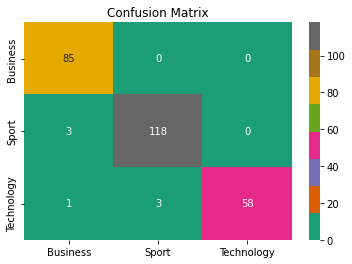

In [ ]:
# Confusion Matrix
confsionM(y2_test, y2_pred)

Term Document Matrix

In [ ]:
# Term Document Matrix 
doc_term = term_doc_matrix(X2_train_vecTranform, vec_fit)
doc_term

,said,wa,ha,game,year,hi,thi,mr,play,new,compani,firm,use,player,peopl,time,market,world,win,sale,bank,share,make,like,england,news,club,say,mobil,team,unit,set,price,technolog,month,onlin,just,final,phone,expect,...,amsterdam,habit,87,sum,resist,attitud,navig,narrow,assum,ye,laid,explod,necessarili,wise,behalf,path,collabor,firewal,inevit,properli,radic,whilst,subsequ,hide,hot,compromis,expos,embrac,hook,overwhelm,flash,immers,relev,repeatedli,vega,compat,embarrass,stream,notic,savvi
0,0.052382,0.014323,0.080150,0.000000,0.047294,0.000000,0.033056,0.076393,0.000000,0.000000,0.000000,0.000000,0.023235,0.026040,0.096243,0.019897,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.044703,0.068887,0.000000,0.049133,0.000000,0.000000,0.077527,0.000000,0.000000,0.026040,0.000000,0.094551,0.000000,0.025390,0.024776,0.000000,0.038520,0.000000,...,0.000000,0.059689,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.047589,0.000000,0.024272,0.089150,0.028644,0.038101,0.030032,0.000000,0.090163,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.344304,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.044638,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.046133,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.055895,0.030567,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052949,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.053948,0.000000,0.000000,0.000000,0.000000,0.000000,0.047701,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.051632,0.000000,0.158622,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.038384,0.035799,0.000000,0.016899,0.011239,0.070870,0.000000,0.000000,0.065478,0.076642,0.000000,0.062267,0.013957,0.012896,0.010664,0.000000,0.012056,0.000000,0.000000,0.000000,0.000000,0.000000,0.036922,0.000000,0.013167,0.000000,0.012586,0.000000,0.000000,0.000000,0.000000,0.000000,0.016893,0.012967,0.027217,0.013279,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.032437,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.032437,0.031992,0.000000,0.000000
4,0.096130,0.000000,0.000000,0.000000,0.000000,0.051309,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.063716,0.000000,0.000000,0.000000,0.055040,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083066,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

### 4.1.Use MultinomialNB: Only Content

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.5min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 458 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.2s finished



--------------------------------------------------
Multinomial Naive Bayes And X is Only Content
--------------------------------------------------

Best Parameters From Fetures Extraction Process
tfidf__tokenizer: <function lemma_tokenizer_w_pos_tag at 0x7f5f6e479200>
tfidf__stop_words: english
tfidf__ngram_range: (1, 1)
tfidf__min_df: 5
Best Score in Tuning: 97.856 %

--------------------------------------------------

X Train: (1072, 4803)
X Test: (268, 4803)
Train Accuracy: 98.601 %
Test Accuracy: 97.015 %
ROC Socre: 99.827 %

--------------------------------------------------

Best Parameters From Tuning Model: MultinomialNB(alpha=1.023292992280754, class_prior=None, fit_prior=True)
--------------------------------------------------



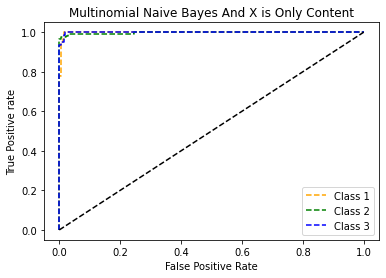

In [ ]:
# Find Best Parameters in Fetures Extraction Process
tokenizer_name, n_gramRange, num_min_df, bestScore_fet, X1_train, X1_test, y1_train, y1_test, bestParam_fet = find_best_param_feturesXtraction(X1, y, MultinomialNB())

# tranform data
X1_train_vecTranform, X1_test_vecTranform, y1_train, y1_test, vec_fit = tranform_data(tokenizer_name, num_min_df, n_gramRange, X1_train, X1_test, y1_train, y1_test)

# model
model, y1_pred_train, y1_pred, y1_prob_pred, y1_test, best_param = tune_naiveBayes_classifier(X1_train_vecTranform, X1_test_vecTranform, y1_train, y1_test)

# plot roc
model_name, type_X, train_acc, test_acc, roc_auc, bestParam_fet, best_param = plot_roc(model, y1_pred_train, y1_pred, y1_prob_pred, y1_train, y1_test, 'Multinomial Naive Bayes', 'Only Content', X1_train_vecTranform.shape, X1_test_vecTranform.shape, best_param, bestParam_fet, bestScore_fet)

# keep data for conclusion
conclusion['Model Name'].append(model_name)
conclusion['Type of Data'].append(type_X)
conclusion['Train Accuracy(%)'].append(train_acc)
conclusion['Test Accuaracy(%)'].append(test_acc)
conclusion['ROC Score(%)'].append(roc_auc)

Confusion Matrix

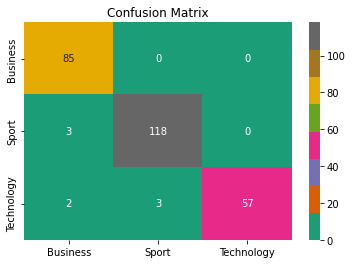

In [ ]:
# Confusion Matrix
confsionM(y1_test, y1_pred)

Term Document Matrix 

In [ ]:
# Term Document Matrix 
doc_term = term_doc_matrix(X1_train_vecTranform, vec_fit)
doc_term

,say,year,game,u,mr,win,company,new,people,player,firm,play,time,world,make,market,sale,news,england,come,use,club,bank,team,mobile,share,month,online,technology,rise,just,price,set,phone,service,like,good,second,country,match,...,gps,incoming,purely,receiver,backer,minimum,tampa,practical,reasonable,obliged,mounted,powered,deemed,backwards,compromised,transmitted,wgbh,meaningless,uncomfortable,bang,newer,vastly,merely,dance,commonplace,radically,uptake,longest,obtain,boat,simultaneously,ricardo,reflection,specify,revolutionary,deserved,surf,writing,sadly,reveals
0,0.050011,0.047066,0.000000,0.000000,0.07606,0.000000,0.000000,0.000000,0.095683,0.025888,0.000000,0.000000,0.019986,0.000000,0.040484,0.000000,0.000000,0.048916,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.078332,0.000000,0.000000,0.025279,0.094386,0.000000,0.024631,0.000000,0.026491,0.038416,0.000000,0.078138,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
1,0.050684,0.031799,0.099010,0.000000,0.00000,0.350977,0.000000,0.000000,0.000000,0.000000,0.000000,0.103695,0.000000,0.000000,0.000000,0.000000,0.000000,0.049575,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.051239,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2,0.048214,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.049321,0.000000,0.000000,0.039029,0.049616,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.046377,0.000000,0.000000,0.000000,0.142478,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
3,0.007212,0.018099,0.000000,0.048447,0.00000,0.000000,0.082004,0.070385,0.013798,0.014933,0.000000,0.000000,0.011529,0.012916,0.011676,0.000000,0.000000,0.014108,0.000000,0.012721,0.044598,0.000000,0.000000,0.00000,0.000000,0.000000,0.013874,0.029164,0.018148,0.000000,0.014208,0.000000,0.000000,0.000000,0.017929,0.030048,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.039663,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.039663,0.000000
4,0.085813,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.059228,0.000000,0.000000,0.000000,0.051228,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.077214,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066904,0.073191,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000

### 4.2.Use MultinomialNB: Heading + Content

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 11.4min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 396 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.3s finished



--------------------------------------------------
Multinomial Naive Bayes And X is Heading + Content
--------------------------------------------------

Best Parameters From Fetures Extraction Process
tfidf__tokenizer: <function stem_tokenizer_porter at 0x7f5f6eb18dd0>
tfidf__stop_words: english
tfidf__ngram_range: (1, 1)
tfidf__min_df: 3
Best Score in Tuning: 97.95 %

--------------------------------------------------

X Train: (1072, 6041)
X Test: (268, 6041)
Train Accuracy: 98.881 %
Test Accuracy: 97.015 %
ROC Socre: 99.828 %

--------------------------------------------------

Best Parameters From Tuning Model: MultinomialNB(alpha=1.023292992280754, class_prior=None, fit_prior=True)
--------------------------------------------------



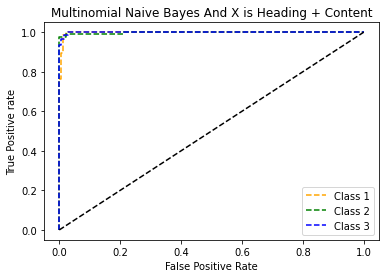

In [ ]:
# Find Best Parameters in Fetures Extraction Process
tokenizer_name, n_gramRange, num_min_df, bestScore_fet, X2_train, X2_test, y2_train, y2_test, bestParam_fet = find_best_param_feturesXtraction(X2, y, MultinomialNB())

# tranform data
X2_train_vecTranform, X2_test_vecTranform, y2_train, y2_test, vec_fit = tranform_data(tokenizer_name, num_min_df, n_gramRange, X2_train, X2_test, y2_train, y2_test)

# model
model, y2_pred_train, y2_pred, y2_prob_pred, y2_test, best_param = tune_naiveBayes_classifier(X2_train_vecTranform, X2_test_vecTranform, y2_train, y2_test)

# plot roc
model_name, type_X, train_acc, test_acc, roc_auc, bestParam_fet, best_param = plot_roc(model, y2_pred_train, y2_pred, y2_prob_pred, y2_train, y2_test, 'Multinomial Naive Bayes', 'Heading + Content', X2_train_vecTranform.shape, X2_test_vecTranform.shape, best_param, bestParam_fet, bestScore_fet)

# keep data for conclusion
conclusion['Model Name'].append(model_name)
conclusion['Type of Data'].append(type_X)
conclusion['Train Accuracy(%)'].append(train_acc)
conclusion['Test Accuaracy(%)'].append(test_acc)
conclusion['ROC Score(%)'].append(roc_auc)

Confusion Matrix

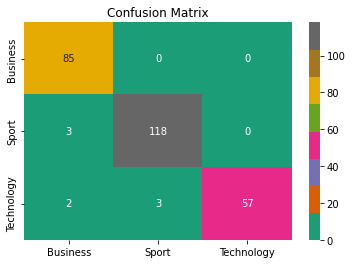

In [ ]:
# Confusion Matrix
confsionM(y2_test, y2_pred)

Term Document Matrix 

In [ ]:
# Term Document Matrix 
doc_term = term_doc_matrix(X2_train_vecTranform, vec_fit)
doc_term

,said,wa,ha,game,year,hi,thi,mr,play,new,use,peopl,compani,firm,player,time,market,world,win,bank,sale,mobil,england,like,make,news,share,say,club,team,technolog,price,onlin,phone,month,set,unit,just,expect,servic,...,sleek,eidur,cutback,feroci,urgenc,1900,despatch,guilt,fm,decathlet,variat,furthermor,emin,cumbersom,newton,plight,inaccur,unhealthi,dishearten,odditi,synonym,endlessli,pastim,travi,lightweight,23rd,surprisingli,midday,embassi,forgot,bird,syndic,dispens,razor,coder,standpoint,crystallin,invari,tin,potato
0,0.047617,0.013020,0.072859,0.000000,0.042992,0.000000,0.030049,0.069445,0.000000,0.000000,0.021121,0.087489,0.000000,0.000000,0.023671,0.018087,0.000000,0.000000,0.000000,0.000000,0.000000,0.070475,0.000000,0.062621,0.040637,0.044664,0.000000,0.000000,0.000000,0.000000,0.085950,0.000000,0.023080,0.035017,0.000000,0.023671,0.000000,0.022522,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.064724,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.046922,0.000000,0.023932,0.087900,0.028243,0.037566,0.029611,0.000000,0.088899,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.339476,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.044012,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045487,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.048013,0.026257,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045483,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.046341,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040975,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.044351,0.000000,0.000000,0.136255,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.037013,0.034520,0.000000,0.016295,0.010837,0.068338,0.000000,0.000000,0.063138,0.060042,0.012435,0.073903,0.000000,0.013458,0.010283,0.000000,0.011626,0.000000,0.000000,0.000000,0.000000,0.000000,0.035603,0.000000,0.012697,0.000000,0.012136,0.000000,0.000000,0.016289,0.000000,0.026245,0.000000,0.012504,0.000000,0.000000,0.012805,0.00000,0.016158,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038088,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.081173,0.000000,0.000000,0.000000,0.000000,0.043325,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.053803,0.000000,0.000000,0.046476,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070141,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

## **Conclusion**



> จากการทดลองพบว่า ชุดข้อมูลที่ให้ความแม่นยำในการพยากรณ์ที่สูงที่สุดคือ ***Heading + Content*** คู่กับ ***Logistic Regression Model*** ซึ่งมีรายละเอียดของพารามิเตอร์ต่างๆดังนี้

* Best Parameters in Fetures Extraction
  * tokenizer: stem_tokenizer_porter
  * stop_words: english
  * ngram_range: (1, 1)
  * min_df: 8
  * Best Score in Tuning: 98.043 %

* Best Parameters in Tuning Model (Logistic Regression)
  * C: 3.5938136638046276
  * penalty: l2
  * solver: liblinear

* ค่าความแม่นยำ
  * Test Accuracy: 98.507463 %
  * ROC Score: 99.886494 %




---



ในที่นี้จะเห็นเพียงว่าการใช้ข้อมูลที่เป็นรูปแบบ Heading + Content จะให้ความแม่นยำสูงเฉพาะในส่วนของ Logistic Regression เท่านั้น และในบาง Classifier ก็ให้ค่าความแม่นยำที่น้อยกว่าหรือเท่ากับชุดข้อมูล Only Content (การใช้ข้อมูล รูปแบบ Heading + Content ไม่ได้มีการให้น้ำหนักเพิ่มเป็นพิเศษ ทำการ Feature Extraction เหมือนข้อมูล Only Content ทุกอย่าง) แต่ Classifier ที่ให้ค่าความแม่นยำที่สูงที่สุดคือ Logistic Regression และการทำ Tokenizer แบบ Porter Stemmer ทำให้ค่าความแม่นยำดีที่สุด(ทุกการทำ Feature Extraction ที่จูนแล้วพบว่าใช้ Tokenizer แบบ Porter Stemmer ทั้งหมด)


In [ ]:
df_conclusion = pd.DataFrame(conclusion)
df_conclusion

,Model Name,Type of Data,Train Accuracy(%),Test Accuaracy(%),ROC Score(%)
0,Logistic Regression,Only Content,99.906716,98.134328,99.902249
1,Logistic Regression,Heading + Content,99.906716,98.507463,99.886494
2,KNeighbors Classifier,Only Content,97.574627,96.268657,99.521551
3,KNeighbors Classifier,Heading + Content,97.854478,95.895522,98.564941
4,Gradient Boosting Classifier,Only Content,100.000000,97.388060,99.785883
5,Gradient Boosting Classifier,Heading + Content,100.000000,97.388060,99.806941
6,Multinomial Naive Bayes,Only Content,98.600746,97.014925,99.827071
7,Multinomial Naive Bayes,Heading + Content,98.880597,97.014925,99.828034


Text(0.5, 1.0, 'Conclusion')

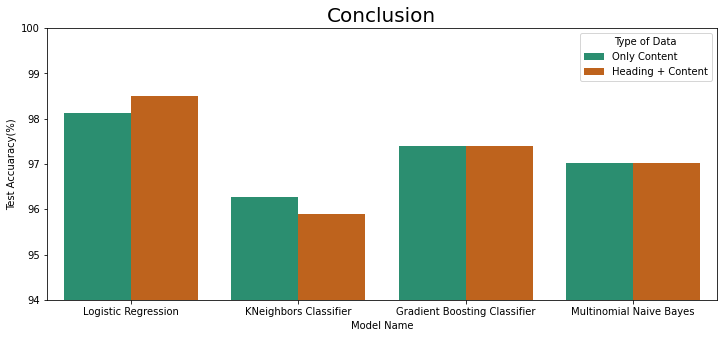

In [ ]:
f, ax = plt.subplots(figsize = (12,5))
ax = sns.barplot(x="Model Name", y="Test Accuaracy(%)", hue="Type of Data", data=df_conclusion, palette="Dark2")
ax.set_ylim(94, 100)
ax.set_title('Conclusion', fontsize=20)